# RFM Analysis and Customer Segmentation
## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE



## Loading Data

In [2]:
transactions = pd.read_csv('data/transactions.csv')
customers = pd.read_csv('data/customers.csv')
campaign = pd.read_csv('data/campaign.csv')

# Preview the data
print("Transactions Data:")
print(transactions.head())
print("\nCustomers Data:")
print(customers.head())
print("\nCampaign Data:")
print(campaign.head())



Transactions Data:
        CardID      Date  Amount
0  C0100000199  20010820  229.00
1  C0100000199  20010628  139.00
2  C0100000199  20011229  229.00
3  C0100000343  20010727   49.00
4  C0100000343  20010202  169.99

Customers Data:
        CardID MaritalStatus  NumChildren       LoS   HHIncomeMed
0  C0100000199             S            4  1.156164  71079.744865
1  C0100000343           NaN            1  3.002740  79424.115726
2  C0100000375             S            0  0.068493  41878.414258
3  C0100000482             S            1  1.356164  62924.588763
4  C0100000689             M            3  2.484932  46616.718039

Campaign Data:
        CardID Responded
0  C0100000199         F
1  C0100000343         F
2  C0100000375         F
3  C0100000482         F
4  C0100000689         F


## Calculating RFM

In [3]:
# RFM Calculation
print("\nCalculating RFM Values...")

# 1. Recency (Days since last purchase)
transactions['Date'] = pd.to_datetime(transactions['Date'].astype(str), format='%Y%m%d')
latest_date = transactions['Date'].max()
transactions['Recency'] = (pd.to_datetime(latest_date) - pd.to_datetime(transactions['Date'])).dt.days
recency_df = transactions.groupby('CardID')['Recency'].min().reset_index()

# 2. Frequency (Number of purchases)
frequency_df = transactions.groupby('CardID')['Date'].count().reset_index()
frequency_df.columns = ['CardID', 'Frequency']

# 3. Monetary (Total amount spent)
monetary_df = transactions.groupby('CardID')['Amount'].sum().reset_index()
monetary_df.columns = ['CardID', 'Monetary']

# Merge RFM data
rfm = recency_df.merge(frequency_df, on='CardID').merge(monetary_df, on='CardID')

print("\nRFM Data:")
print(rfm.head())




Calculating RFM Values...

RFM Data:
        CardID  Recency  Frequency  Monetary
0  C0100000199        1          3    597.00
1  C0100000343      114          6    700.94
2  C0100000375       59          4    223.98
3  C0100000482       20          4    197.98
4  C0100000689        4          2    428.00


In [4]:
rfm = rfm # Replace with your actual file path

# Scoring RFM values based on quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RFM scores into a single segment code
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Assigning customer segments based on RFM segments
def assign_segment(row):
    if row['RFM_Segment'] == '555':
        return 'Soulmates'
    elif row['R_Score'] == 1 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'Ex-Lovers'
    elif row['R_Score'] == 5 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return 'Apprentice'
    elif row['F_Score'] >= 4 and row['M_Score'] >= 4 and row['R_Score'] >= 4:
        return 'Lovers'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Display the processed RFM table
rfm_display = rfm[['CardID', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'Segment']]
rfm_display.to_csv("processed_rfm_table.csv", index=False)  # Save the table as a CSV file
rfm_display.head()  # Display the first few rows in the notebook


,CardID,R_Score,F_Score,M_Score,RFM_Segment,Segment
0,C0100000199,5,2,4,524,Other
1,C0100000343,2,5,5,255,Other
2,C0100000375,3,3,2,332,Other
3,C0100000482,4,3,2,432,Other
4,C0100000689,5,1,4,514,Other


In [5]:
# Normalize RFM values
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']]), columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled['CardID'] = rfm['CardID']
print(rfm_scaled.head())

# RFM Segmentation
print("\nSegmenting Customers...")
for i in range(6):
    kmeans = KMeans(n_clusters=2 + i, random_state=42)
    rfm['RFM_Segment_' + str(i)] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Merge with Socio-Demographic Data
full_data = rfm.merge(customers, on='CardID')

# Campaign Response Classification
print("\nClassifying Campaign Response...")
data_with_response = full_data.merge(campaign, on='CardID')
X = data_with_response[['Recency', 'Frequency', 'Monetary', 'HHIncomeMed', 'NumChildren', 'LoS']]
y = data_with_response['Responded']
y = y.map({'F': 0, 'T': 1})

    Recency  Frequency  Monetary       CardID
0 -1.029144  -0.375675  0.473691  C0100000199
1  0.365664   0.075486  0.766177  C0100000343
2 -0.313225  -0.225288 -0.575983  C0100000375
3 -0.794619  -0.225288 -0.649147  C0100000482
4 -0.992114  -0.526062 -0.001874  C0100000689

Segmenting Customers...

Classifying Campaign Response...



Visualizing Clusters...


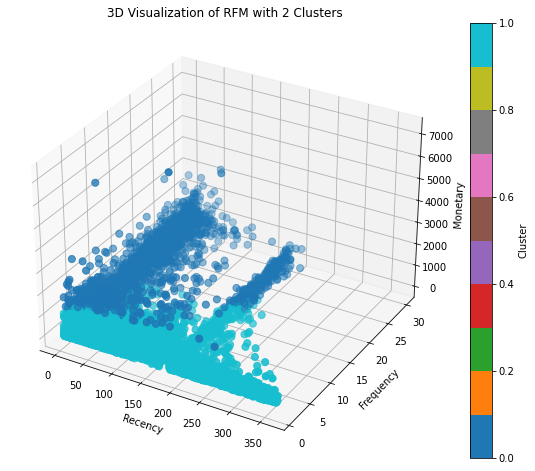

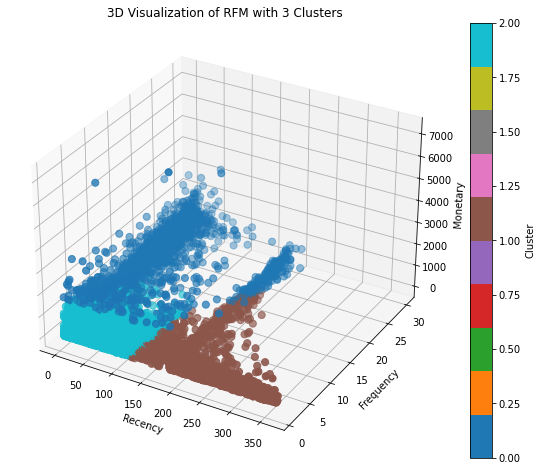

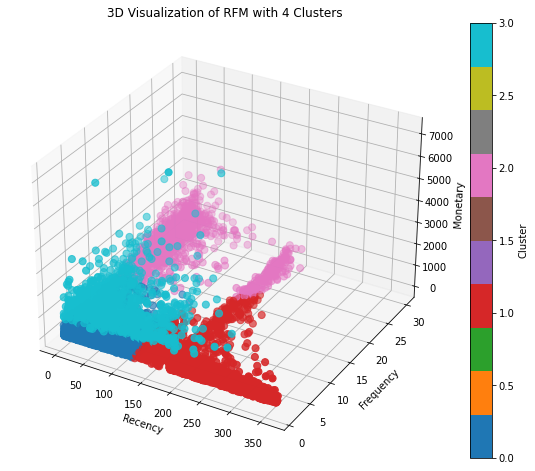

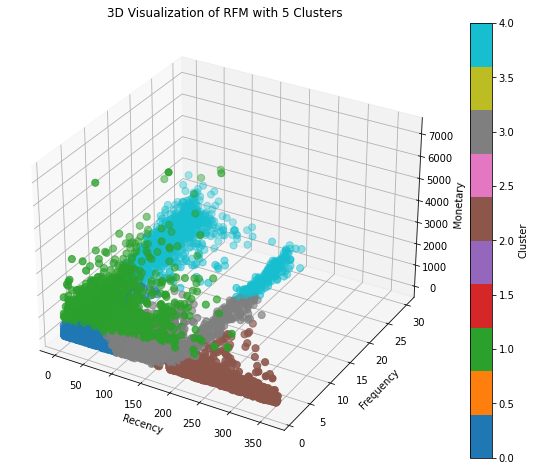

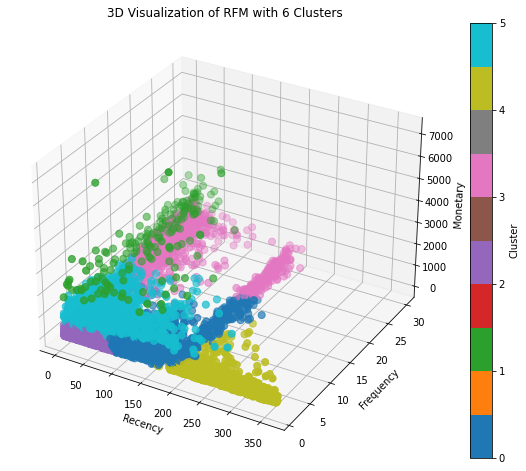

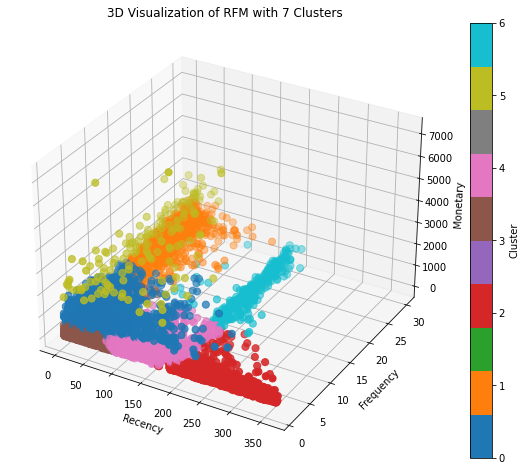

In [6]:
# Visualizing the Clusters from RFM Segmentation
print("\nVisualizing Clusters...")

# 3D Visualization of RFM Clusters
for i in range(6):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        rfm['Recency'],
        rfm['Frequency'],
        rfm['Monetary'],
        c=rfm['RFM_Segment_' + str(i)],
        cmap='tab10',
        s=50
    )
    ax.set_title("3D Visualization of RFM with " + str(i+2) + " Clusters")
    ax.set_xlabel("Recency")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Monetary")
    plt.colorbar(sc, label='Cluster')
    plt.show()

In [12]:
# Update segmentation logic to include specific outbound customer segments
def assign_outbound_segment(row):
    if row['R_Score'] in [4, 5] and row['F_Score'] in [4, 5]:
        return 'High Retention - Outbound'
    elif row['R_Score'] in [1, 2] and row['M_Score'] in [4, 5]:
        return 'High Spender - Reengagement'
    elif row['F_Score'] in [1, 2] and row['R_Score'] in [4, 5]:
        return 'Low Frequency - High Recency'
    else:
        return 'Other'

# Apply updated segmentation logic
rfm['Business_Segment'] = rfm.apply(assign_outbound_segment, axis=1)

# Display updated segmentation results
print("Updated RFM with Business-Oriented Segments:")
print(rfm[['CardID', 'R_Score', 'F_Score', 'M_Score', 'Business_Segment']].head())


Updated RFM with Business-Oriented Segments:
        CardID  R_Score  F_Score  M_Score              Business_Segment
0  C0100000199        5        2        4  Low Frequency - High Recency
1  C0100000343        2        5        5   High Spender - Reengagement
2  C0100000375        3        3        2                         Other
3  C0100000482        4        3        2                         Other
4  C0100000689        5        1        4  Low Frequency - High Recency


In [13]:
# Merge RFM data with customers dataset for detailed descriptions
enhanced_data = rfm.merge(customers, on='CardID')

# Group by business segment and summarize socio-demographic features
segment_descriptions = enhanced_data.groupby('Business_Segment').agg({
    'MaritalStatus': lambda x: x.value_counts().idxmax(),  # Most common marital status
    'NumChildren': 'mean',  # Average number of children
    'LoS': 'mean',          # Average length of stay
    'HHIncomeMed': 'mean'   # Median household income
}).reset_index()

# Print segment descriptions
print("Segment Descriptions:")
print(segment_descriptions)

Segment Descriptions:
               Business_Segment MaritalStatus  NumChildren       LoS  \
0     High Retention - Outbound             S     1.093487  1.274931   
1   High Spender - Reengagement             S     1.100000  1.404567   
2  Low Frequency - High Recency             M     1.131887  0.936573   
3                         Other             M     1.145575  1.363928   

    HHIncomeMed  
0  60840.554765  
1  57355.583361  
2  58011.653701  
3  58034.812437  


In [15]:
# Perform clustering analysis on RFM data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Merge with customers dataset for detailed cluster analysis
clustered_data = rfm.merge(customers, on='CardID')

# Summarize cluster characteristics
cluster_descriptions = clustered_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'MaritalStatus': lambda x: x.value_counts().idxmax(),
    'NumChildren': 'mean',
    'LoS': 'mean',
    'HHIncomeMed': 'mean'
}).reset_index()

# Print cluster descriptions
print("Cluster Descriptions:")
print(cluster_descriptions)

Cluster Descriptions:
   Cluster     Recency  Frequency     Monetary MaritalStatus  NumChildren  \
0        0   48.220174   3.310466   323.191985             M     1.134355   
1        1  207.275886   2.976483   259.319849             M     1.155493   
2        2   42.176787  23.420446   835.798155             S     1.082244   
3        3   57.510818   5.500470  1116.118344             S     1.082785   

        LoS   HHIncomeMed  
0  1.184302  58227.240110  
1  1.455661  57330.277533  
2  1.323172  63817.657465  
3  1.389435  55463.201927  


# Shluková analýza a závěry

## Popisy klastrů

### **Klastr 0**
- **Recence**: Zákazníci mají středně dlouhou dobu od posledního nákupu (v průměru 48 dní).
- **Frekvence**: Relativně nízká frekvence nákupů (v průměru 3,3 nákupu).
- **Monetární**: Průměrná výše útraty: 323 USD.
- **Demografické údaje**:
  - **Rodinný stav**: Převážně ženatí zákazníci.
  - **Počet dětí**: Nízký průměrný počet dětí (~1,13).
  - **Délka pobytu (LoS)**: Relativně krátký, přibližně 1,18 roku.
  - **Příjem domácnosti (HHIncomeMed)**: Medián příjmu domácnosti je ~58 227 USD.

### **Klastr 1**
- **Doba trvání**: Dlouhá doba trvání (207 dní), což naznačuje, že zákazníci již nejsou mezi námi.
- **Frekvence**: Nízká frekvence nákupů (průměrně 2,97 nákupu).
- **Monetární**: Nízké výdaje s průměrnou hodnotou 259 USD.
- **Demografické údaje**:
  - **Rodinný stav**: Převážně ženatí zákazníci.
  - **Počet dětí**: V průměru o něco více dětí (~1,16).
  - **LoS**: Relativně delší pobyt, přibližně 1,46 roku.
  - **HHIncomeMed**: Mírně nižší průměrný příjem ~57 330 USD.

### **Klastr 2**
- **Doba trvání**: Velmi čerství kupující (42 dní).
- **Frekvence**: Vysoká frekvence nákupů (23,4 nákupů).
- **Peněžní**: Velmi vysoké výdaje s průměrnou částkou 835 USD.
- **Demografické údaje**:
  - **Rodinný stav**: Převážně svobodní zákazníci.
  - **Počet dětí**: Málo dětí (~1,08).
  - **LoS**: Mírný pobyt 1,32 roku.
  - **Příjmový průměr**: Vyšší mediánový příjem ~63 818 USD.
### **Klastr 3**
- **Recence**: Středně noví kupující (57 dní).
- **Frekvence**: Střední frekvence nákupů (5,5 nákupu).
- **Monetární**: Nejvíce utrácející s průměrnou částkou 1 116 USD.
- **Demografické údaje**:
  - **Rodinný stav**: Převážně svobodní zákazníci.
  - **Počet dětí**: Málo dětí (~1,08).
  - **LoS**: Mírný pobyt 1,39 roku.
  - **Příjmový průměr**: Nejnižší mediánový příjem (~55 463 USD).

---

## Poznatky a využitelné závěry

### **Klastr 0 (mírné zapojení, mírné výdaje)**
- **Znalost**: Tito zákazníci jsou stálými, ale ne častými zákazníky. Utrácejí střídmě a mají tendenci být ženatí s mírně vyššími příjmy.
- **Akce**: Zaměřte se na ně pomocí věrnostních kampaní a exkluzivních slev, abyste podpořili vyšší útratu a četnost.

### **Klastr 1 (Neplatící, málo utrácející)**
- **Znalost**: Jedná se o zákazníky s nízkou frekvencí a útratou. Jsou to především ženatí a vdané s mírně vyšší délkou pobytu, ale nižšími příjmy.
- **Akce**: Použijte kampaně pro opětovné zapojení s personalizovanými nabídkami nebo upomínkami. Zdůrazněte produkty orientované na hodnotu, abyste oslovili jejich nižší výdajové zvyklosti.

### **Klastr 2 (vysoká frekvence, vysoké výdaje)**

- **Pohled**:Jedná se o vaše nejlepší zákazníky s vysokou útratou a frekvencí. Jsou převážně svobodní, s vyššími příjmy domácnosti a střední délkou pobytu.
- **Akce**: Udržení je klíčové - nabídněte VIP výhody, dřívější přístup k produktům nebo exkluzivní propagační akce, abyste si udrželi angažovanost.Tuto skupinu lze také využít k pilotnímu ověření nových produktů nebo služeb.

### **Klastr 3 (vysoká útrata, střední frekvence)**
- **Znalost**:Lidé s vysokými výdaji a střední frekvencí, převážně svobodní a s nejnižším příjmem domácnosti mezi shluky.
- **Akce**: Zaměřte se na křížový prodej a upselling.
Poskytněte doporučení prémiových produktů nebo předplacených služeb, abyste využili jejich vysokou peněžní hodnotu.

---

## Celkové závěry

### **Demografické vzorce**
- Ženatí zákazníci (shluky 0 a 1) mají tendenci utrácet méně a zapojovat se méně často ve srovnání se svobodnými zákazníky (shluky 2 a 3).
- U svobodných zákazníků je větší pravděpodobnost, že budou nakupovat s vysokou hodnotou, vyššími výdaji a vyšší četností.
### **Strategie zapojení**
- Diferencujte kampaně pro zákazníky, kteří již nenakupují (shluk 1), a zákazníky s vysokou hodnotou (shluk 2 a 3).
- Využijte vzorce příjmů a výdajů k přizpůsobení nabídek - prémiové produkty pro zákazníky s vysokými příjmy a vysokou frekvencí a slevy nebo balíčky pro skupiny s nižšími příjmy.

### **Zaměření na udržení**

- Klastry 2 a 3 by měly být vzhledem k vysokým výdajům a četnosti prioritami pro udržení.
- Klastry 0 a 1 vyžadují úsilí o zvýšení angažovanosti a výdajů s personalizovanými strategiemi, které odpovídají jejich demografickým charakteristikám.